Team members:  
    brandena  
    cjh2960  
    pseise  

Hypothesis:  
    User got data out via device use or email.  
    Probably by a non-employee or previous employee.
    
    IMPORTANT NOTE:
        It appears that the year in the data was changed from 2004 to 2017, without any corresponding changes
        in the rest of the data.   
        That significantly impacts how the workweek is set up (wed-sun, rather than mon-fri) and also changes
        the dates on which holidays fall.  
        This is a really cool assignment, but that will make things quite confusing.  

Planned Next Steps:  
    1. Find outliers via time visualization or normal distribution
       a. Histogram: bucket is 1 hour, range is 1 week, for all data with datetime
       b. Normal distribution programatically find outliers.
       c. Pair employees and pc correlations both ways
    2. Group by role, repeat above
    3. Group by period of time (day, week, month)
    4. Find non-employees activity

Potentially suspicious activities:  

    device:  
        disconnect without connect  
        irregular pattern of connect/disconnect  
        strange time  
        large number unique pc  
        not normal pc  
        large number activity in short time frame  
        short session  
  
    email:  
        large size  
        many attachments  
        strange time  
        to and from same  

    employee:  
        those who are fired  
        it role  
        short term employees  
        new supervisor  
        rare role  

    HTTP:  
        rare url use  
        rare domain and large number unique url  
        single pc large number url  
        strange time  

    logon:  
        pc with rare user  
        rare pc with user  
        non-computer lab pc  
        logoff without logon  
        strange time  
        non-assigned user on pc  
        many logon to single logoff  

    device and email:  
        close time frame device activity and email sent  

    device and employee:  
        user connect and not employed  
        user connect and was employed  
        user connect and non-technical role  

    device and HTTP:  
        rare url and device activity    
        close time frame device activity and url  
        close time frame device activity and company url  

    device and logon:  
        device activity and no logon  
        device activity and not-assigned pc  
        device activity and rare pc  
        close time frame device activity and logon activity  
        same pc, very close time device disconnect and logoff  
        same pc, very close time device connect and logon  

    email and employee:  
        from user and not employed  
        to user and not employed  
        large number unique pc and not it user  
        no more emails user and supervisor  

    email and HTTP:  
        close time frame large email and rare url  

    email and logon:  
        email and not logged on  
        close time frame email and logon on non-assigned pc  
        not close time frame email and logon activity (termination)  

    employee and HTTP:  
        url access and not employed user  
        non-standard url for each role  

    employee and logon:  
        logon activity and not employeed user  
        many logons unique pc and not it  
        many logons unique pc and not supervisor of pc  
        logon user not it and it pc  
        logon user not technical and technical pc  
        logon user not supervisor and supervisor pc  

    HTTP and logon:  
        url activity and not logged on  
        url activity and repeated logon  


In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import nose.tools
import pandas as pd
import datetime
import calendar

%matplotlib inline
%matplotlib notebook


# Data files:

dataFolder = "SecurityData/SecurityData/"

print("1/5..Loading device data")
devices = pandas.read_csv(dataFolder + 'device_info.csv').rename(columns={'user': 'user_id'})

print("2/5..Loading email data")
emails = pandas.read_csv(dataFolder + 'email_info.csv')

print("3/5..Loading employee data")
employees = pandas.read_csv(dataFolder + 'employee_info.csv')

print("4/5..Loading http data")
http = pandas.read_csv(dataFolder + 'http_info.csv').rename(columns={'user': 'user_id'})

print("5/5..Loading log-on data")
logon = pandas.read_csv(dataFolder + 'logon_info.csv').rename(columns={'user': 'user_id'})


def fixDates(data):
    for i, r in data.iterrows():
        l = list(r["date"])
#         print(r["date"])
        l[8:10] = "0", "4"
        r["date"] = "".join(l)
#         break
#     print(data["date"])

print("Fixing device dates")
fixDates(devices)
print("Fixing emails dates")
fixDates(emails)
print("Fixing http dates")
fixDates(http)
print("Fixing logon dates")
fixDates(logon)
print("Done fixing dates.")

1/5..Loading device data
2/5..Loading email data
3/5..Loading employee data
4/5..Loading http data
5/5..Loading log-on data
Fixing device dates
Fixing emails dates
Fixing http dates
Fixing logon dates
Done fixing dates.


In [2]:
# Functions to allowing grouping by hour of the weekday - so all events at 4pm on a monday get
# put in the same bucket
def dateConversionWrapper(dateStr):
    d = datetime.datetime.strptime(dateStr, '%m/%d/%Y %H:%M:%S')
    dayName = calendar.day_name[d.weekday()]
    result = str(d.weekday()) + ("_%02d_" % d.hour) + dayName
    return result

def groupbyByHour_Weekday(orig_data, excludeWorkingHours=False):
    print("Grouping by hour/weekday")
    data = orig_data[["id", "date"]].copy()
    data["dayHour"] = data["date"].apply(dateConversionWrapper)
    dataGroups = data.groupby("dayHour")
    hourCounts =  dataGroups["id"].count()
    if excludeWorkingHours:
        hourCounts = hourCounts[[(int(s[2:4]) < 6 or int(s[2:4]) > 19) for s in hourCounts.index]]
    return hourCounts

Grouping by hour/weekday


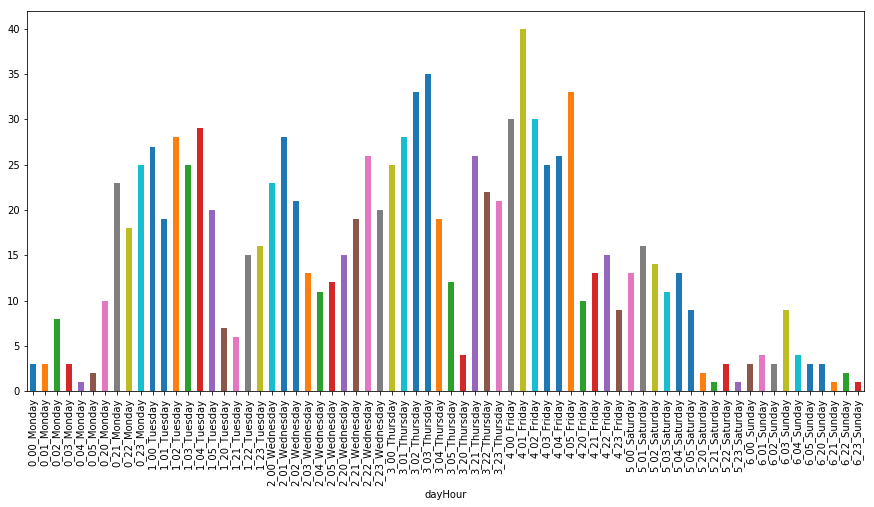

In [3]:
# make figure take full width
plt.rcParams["figure.figsize"] = [15, 7]

#show plot of when devices were inserted/removed outside of regular business hours
groupbyByHour_Weekday(devices, excludeWorkingHours=True).plot.bar()

Notice in the above, that there tend to be surges from 1-3am, every morning. 

Grouping by hour/weekday


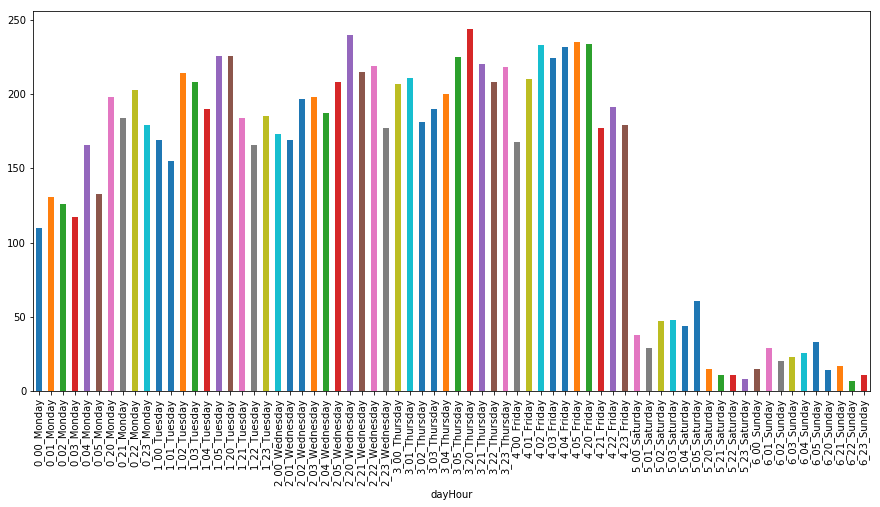

In [4]:

# same, but for log-on events
'''
//It appears that in the data, most people are working 5 days a week, wednesday through sunday. That is strange, 
//but seems pretty evident. I'd assume that it's just some bug in my code, but I can look and all the "normal"
//people who login exactly twice a day (see below) started working the third of May, 2017, for instance.
//Which is clearly a Wednesday. They then go on to work five days, take a break for two, and start again on the 10th,
//which is again a Wednesday.
Data manually corrected to say in 2004
'''

groupbyByHour_Weekday(logon, excludeWorkingHours=True).plot.bar()


In [5]:
#This finds likely pairings between users and their assigned personal computers.

identification = employees[['employee_name', 'user_id']]
# identification = employees[['employee_name', 'role', 'user_id']]
identification = identification.drop_duplicates()
identification = identification.sort_values('user_id')
# print(identification)


#broad data frame of each time a user logged in to each pc
whoseUsing = logon[['user_id', 'pc']]
whoseUsing = whoseUsing.sort_values('user_id')
# print(whoseUsing)

#Creates a more compact data frame that has a count of how many times each user logged in to each PC
#
#Note: could be very useful for attempting to identify people who are using several computers only a few times each.
#Could be suspcious
timesUsed = whoseUsing.groupby(whoseUsing.columns.tolist(),as_index=False).size()
timesUsed = pandas.DataFrame(timesUsed)
# print(timesUsed)

whoseLogin = whoseUsing.groupby(whoseUsing.columns.tolist()).size().reset_index().rename(columns={0:'#Logins'})
whoseLogin = pandas.DataFrame(whoseLogin)
# print(whoseLogin)

matches = whoseLogin.groupby(['user_id'])['#Logins'].transform(max) == whoseLogin['#Logins']
pairs = identification.merge(whoseLogin[matches])
# identification.join(pairs)


'''
We also noticed here that many people had exactly 254 log-on/off events. At first, this looked suspicious - 
like perhaps there was a mistake in our algorithm, or perhaps an rng error when the data was being created, 
but we discovered that there are 128 business days in the time period we're looking at, and so those people 
logged in precisely once, and out precisely once - but, with one un-accounted-for day.
We intend to look into what day most people didn't log in, but which should have been a regular business day.

Furthermore, these people are likely to be good examples of very standard behaviour, and so we can probably
use them as a good benchmark in identifying outliers.
'''

print(pairs)

                 employee_name  user_id       pc  #Logins
0          Anastasia Ava Curry  AAC0070  PC-9582      254
1          Amaya Amy Patterson  AAP0946  PC-6599      353
2              Amir August Roy  AAR0716  PC-8861      357
3        Alfreda Aline Sweeney  AAS0850  PC-5379      358
4         Anthony Bruce Graham  ABG0865  PC-0410      577
5          Akeem Brent Holland  ABH0821  PC-0924      358
6         Aladdin Brody Mclean  ABM0089  PC-0985      254
7            Alma Barbara Moon  ABM0173  PC-1346      254
8      Allegra Brianna Stanton  ABS0125  PC-5641      353
9      Abigail Brianna Terrell  ABT0490  PC-3555      254
10        Amanda Beatrice Wall  ABW0271  PC-3021      254
11          Aiko Candace Brock  ACB0077  PC-6778      254
12           Adele Carol Banks  ACB0393  PC-6420      254
13           Arden Chaim Cohen  ACC0950  PC-8672      569
14            Ali Cullen Perry  ACP0847  PC-2914      254
15               Amy Cara Reid  ACR0100  PC-3207      351
16   Allen Cha

In [6]:
'''
We can then take the above and plug it into the previously-mentioned grouping algorithm, to see what times one of
these standard workers tended to clock-in and out.
We can see, as mentioned above, that for some reason they always work from wednesday to sunday, and
if we examine a particular week, we find that specifically, they work from a few minutes before 9am, until a few 
minutes before 8pm. Not a short day.


Perhaps the year was changed from 2010 to 2017 for some reason without the rest of the data being changed? 
Since 2010 was the most recent year that May 3rd falls on a monday. 
In which case the correct number of business days would be 126, and so that would imply that everyone worked 
one extra day, when most businesses would have been off.
If I manually change the year of all entries to 2010 though, the average person still never works on the weekend,
and so the extra day would have to be some holiday. The 4 public holidays in that time period in 2010 are Memorial 
day on 5/31, independence on 7/5, Labor on 8/6, and columbus day on 10/11.
They worked both 8/6 and 10/11. So I think we can conclude that the year is not supposed to be 2010. It could 
theoretically be a prior year (2004 is the next where may 3rd is a Monday):
The first time they get a day off, looking at the period of days working and days off, is may 31. In 2004, that did
indeed fall on a monday.

Well that makes this difficult. Was this data really broken like that?
'''
normal_logons = groupbyByHour_Weekday(logon[logon['user_id'] == 'ZLW0169'])

print(normal_logons)
for r in logon[logon['user_id'] == 'ZLW0169'].iterrows():
    d = datetime.datetime.strptime(r[1]['date'], '%m/%d/%Y %H:%M:%S')
    dayName = calendar.day_name[d.weekday()]
    print(d, dayName)




Grouping by hour/weekday
dayHour
0_07_Monday       23
0_16_Monday       23
1_07_Tuesday      26
1_16_Tuesday      26
2_07_Wednesday    26
2_16_Wednesday    26
3_07_Thursday     26
3_16_Thursday     26
4_07_Friday       26
4_16_Friday       24
4_17_Friday        2
Name: id, dtype: int64
2004-05-03 07:36:00 Monday
2004-05-03 16:50:00 Monday
2004-05-04 07:45:00 Tuesday
2004-05-04 16:56:00 Tuesday
2004-05-05 07:45:00 Wednesday
2004-05-05 16:54:00 Wednesday
2004-05-06 07:36:00 Thursday
2004-05-06 16:43:00 Thursday
2004-05-07 07:46:00 Friday
2004-05-07 16:57:00 Friday
2004-05-10 07:31:00 Monday
2004-05-10 16:51:00 Monday
2004-05-11 07:47:00 Tuesday
2004-05-11 16:44:00 Tuesday
2004-05-12 07:46:00 Wednesday
2004-05-12 16:45:00 Wednesday
2004-05-13 07:45:00 Thursday
2004-05-13 16:46:00 Thursday
2004-05-14 07:45:00 Friday
2004-05-14 16:43:00 Friday
2004-05-17 07:45:00 Monday
2004-05-17 16:54:00 Monday
2004-05-18 07:31:00 Tuesday
2004-05-18 16:59:00 Tuesday
2004-05-19 07:45:00 Wednesday
2004-05-1

In [7]:

#This finds the outliers in any given category, as defined by their stdev away from the mean.

#Runs rather slowly. Like 5-10 minutes, for all four things. We should probably improve that, if possible.

#Note that this requires the installation of "datetime_truncate":
#    pip install datetime_truncate

from datetime_truncate import truncate

def outliers_date(data, uid_col, mod_type='day', out_percent=0.001):
    data = data.copy()
    if 'date' not in data.columns:
        return 0
    data['date'] = pd.to_datetime(data['date'])
    mod_col = 'mod_' + mod_type
    #norm_col = 'norm_' + mod_type
    data[mod_col] = data['date'].apply(lambda v: int((v - truncate(v, mod_type)).total_seconds()))
    #data[norm_col] = (data[mod_col] - data[mod_col].mean())/data[mod_col].std()
    lower = data[mod_col].quantile(out_percent)
    upper = data[mod_col].quantile(1 - out_percent)
    outliers = data[(data[mod_col] < lower) | (data[mod_col] > upper)]
    return outliers.groupby(uid_col).size().sort_values(ascending=False)
    
print('device:')
print(outliers_date(devices, 'user_id'), "\n")
# print('email:')
# print(outliers_date(emails, 'from'), "\n")
# print('HTTP:')
# print(outliers_date(http, 'user_id'), "\n")
# print('logon:')
# print(outliers_date(logon, 'user_id'), "\n")

device:
user_id
TDB0268    33
WHC0684    32
AYN0502    32
CJP0221    31
XBW0181    18
LXW0999    17
AJM0772    17
YXG0504    15
HAM0510    13
IDM0326    13
TGF0571    11
JAO0817    10
RKS0170    10
CCC0632     9
JWS0948     6
HMR0409     5
BNF0925     4
JRV0778     4
ASN0508     4
BGM0010     4
DGC0484     4
CHH0472     3
CSF0929     2
ABH0821     2
SLO0231     2
JGF0556     2
BRS0849     1
WSP0210     1
VLB0057     1
MTP0573     1
GAP0417     1
JXD0869     1
HPS0247     1
IAB0194     1
JDH0545     1
JNC0320     1
GLH0154     1
dtype: int64 



In [ ]:
# print(lateDevices)
owners = pairs.rename(columns={'user_id': 'owner_id'})[['owner_id', 'pc']]
# print(owners.columns, lateDevices.columns)
late_withOwners = lateDevices[['user_id', 'pc']].merge(owners, on=('pc'), suffixes=('_l', '_r'))
# print(late_withOwners.columns)
late_withOwners = late_withOwners.merge(employees[['user_id', 'employee_name', 'role']], on=('user_id'), suffixes=('_l', '_r'))
# print(late_withOwners.columns)
# print(late_withOwners)
# print(late_withOwners[late_withOwners["owner_id"] != late_withOwners["user_id"]])
late_nonOwners = late_withOwners[late_withOwners["owner_id"] != late_withOwners["user_id"]].drop_duplicates()

print(late_nonOwners)

# temp = late_nonOwners[['pc', 'user_id', 'owner_id', 'role']]